<a href="https://colab.research.google.com/github/Anaghatotade/Separation-Process-course/blob/ipynb/SPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Simulation by only considering recycle**

## Equations Used in the Simulation

The following equations are used to model the material balances across each stage/tray.

---

### 1.Material Balance Equations (Tray-wise)

For each tray, material balances are carried out for benzene, heptane, and ionic liquid in both the extract and raffinate phases.

#### Extract Phase
- **Benzene Extract Flow**  
  `Benzene_Extract = Benzene_Efficiency * Benzene_in_Raffinate`
  
- **Heptane Extract Flow**  
  `Heptane_Extract = Heptane_Efficiency * Heptane_in_Raffinate`

- **IL Flow (constant)**  
  `IL_Extract = 0.79  # mol/h`

#### Raffinate Phase
- **Benzene Raffinate Flow**  
  `Benzene_Raffinate = Benzene_in_Raffinate - Benzene_Extract`

- **Heptane Raffinate Flow**  
  `Heptane_Raffinate = Heptane_in_Raffinate - Heptane_Extract`

---

### 2.Extraction Efficiency
- **Benzene Efficiency**:  
  `Benzene_Efficiency = 0.85`  
  (Fraction of benzene extracted from raffinate into the extract phase.)

- **Heptane Efficiency**:  
  `Heptane_Efficiency = 0.05`  
  (Fraction of heptane extracted into the extract phase.)

---

### 3. Component Flow in Each Tray

- **Total Extract Flow**  
  `Extract_Total = Benzene_Extract + Heptane_Extract + IL_Extract`

- **Total Raffinate Flow**  
  `Raffinate_Total = Benzene_Raffinate + Heptane_Raffinate`

---

### 4. Composition in Extract and Raffinate Phases

#### Extract Phase Composition
- `x_Benzene_extract = Benzene_Extract / Extract_Total`
- `x_Heptane_extract = Heptane_Extract / Extract_Total`
- `x_IL_extract = IL_Extract / Extract_Total`

#### Raffinate Phase Composition
- `x_Benzene_raffinate = Benzene_Raffinate / Raffinate_Total`
- `x_Heptane_raffinate = Heptane_Raffinate / Raffinate_Total`

---

## 5. Benzene Purity in Extract
The purity of benzene in the extract phase is calculated as the mole fraction of benzene in the extract phase:

- `Benzene Purity in Extract = Extract Composition (Benzene)`

---

## 6. Weight Percentage of Benzene in Raffinate
The weight percentage of benzene in the raffinate phase is calculated using the molecular weights of benzene and heptane:

- `Weight % Benzene in Raffinate = 100 ×
(Benzene Flow in Raffinate × Molar Mass of Benzene) /
[(Benzene Flow in Raffinate × Molar Mass of Benzene) + (Heptane Flow in Raffinate × Molar Mass of Heptane)]`

Where:
- Molar Mass of Benzene = 78.11 g/mol
- Molar Mass of Heptane = 100.2 g/mol

---

## 7. Recycle Stream Calculation
In each recycle iteration, the process is updated by recycling the raffinate back into the feed:

### Total Feed Stream (with Recycle):
-`Total Feed = Initial Feed Flow + Benzene Recycle Stream + Heptane Recycle Stream`

### Updated Fractions of Benzene and Heptane in the Feed:
-`New Benzene Fraction =
(Initial Feed Flow × Benzene Fraction in Feed + Benzene Recycle Stream) / Total Feed`

Similarly for heptane.

---

## 8. Convergence Condition for Recycle Streams
At each iteration, the process is expected to converge when the values of the recycle streams stabilize, i.e., when the difference between the recycled streams in successive iterations is minimal.

---

## 9. Recycle Ratio


- `Recycle Ratio =
(Benzene Recycle Stream / Total Feed Flow)`

Where:
- The Benzene Recycle Stream and Heptane Recycle Stream are updated after each iteration based on the raffinate composition from the previous stage.



In [ ]:
import numpy as np
from scipy.optimize import minimize

# Given: Feed and IL stream composition
initial_feed_flow = 55.0  # mol/h
il_flow = 0.79    # mol/h
benzene_in_feed = 0.8625
heptane_in_feed = 0.1374
il_in_feed = 0.0001

# Ask user for number of iterations
try:
    num_iterations = int(input("Enter number of recycle iterations: "))
except ValueError:
    print("Invalid input. Using default of 5 iterations.")
    num_iterations = 5

# Ask user for extract and raffinate flow rate guesses
try:
    user_extract = float(input("Enter initial guess for extract flow (mol/h): "))
    user_raffinate = float(input("Enter initial guess for raffinate flow (mol/h): "))
except ValueError:
    print("Invalid input. Using default initial guesses.")
    user_extract = 25.0
    user_raffinate = 25.0

def run_simulation(feed_flow, benzene_in_feed, heptane_in_feed):
    def extraction_model(x):
        extract_flow, raffinate_flow = x

        total_input = feed_flow + il_flow
        total_output = extract_flow + raffinate_flow

        if total_output > total_input or extract_flow < 0 or raffinate_flow < 0:
            return 1e6

        benzene_in = feed_flow * benzene_in_feed
        heptane_in = feed_flow * heptane_in_feed

        benzene_in_extract = 0.85 * benzene_in
        benzene_in_raffinate = benzene_in - benzene_in_extract

        heptane_in_extract = 0.05 * heptane_in
        heptane_in_raffinate = heptane_in - heptane_in_extract

        il_in_extract = il_flow

        total_extract = benzene_in_extract + heptane_in_extract + il_in_extract
        if total_extract == 0:
            return 1e6

        benzene_purity = benzene_in_extract / total_extract
        return 1 - benzene_purity

    x0 = [user_extract, user_raffinate]
    bounds = [(0, feed_flow + il_flow), (0, feed_flow + il_flow)]
    result = minimize(extraction_model, x0, method='SLSQP', bounds=bounds)

    extract_flow, raffinate_flow = result.x
    benzene_purity = 1 - result.fun if result.fun < 1e6 else 0.0

    benzene_in = feed_flow * benzene_in_feed
    heptane_in = feed_flow * heptane_in_feed

    benzene_extract = 0.85 * benzene_in
    heptane_extract = 0.05 * heptane_in
    il_extract = il_flow
    total_extract = benzene_extract + heptane_extract + il_extract

    benzene_raffinate = benzene_in - benzene_extract
    heptane_raffinate = heptane_in - heptane_extract
    total_raffinate = benzene_raffinate + heptane_raffinate

    return {
        'extract_flow': extract_flow,
        'raffinate_flow': raffinate_flow,
        'benzene_purity': benzene_purity,
        'extract_composition': {
            'benzene': benzene_extract / total_extract,
            'heptane': heptane_extract / total_extract,
            'il': il_extract / total_extract
        },
        'raffinate_composition': {
            'benzene': benzene_raffinate / total_raffinate,
            'heptane': heptane_raffinate / total_raffinate
        },
        'weight_percent_benzene': 100 * (benzene_raffinate * 78.11) / (benzene_raffinate * 78.11 + heptane_raffinate * 100.2),
        'benzene_raffinate': benzene_raffinate,
        'heptane_raffinate': heptane_raffinate,
        'raffinate_total': total_raffinate
    }

# Initial recycle streams
benzene_rcy2 = 0.0
heptane_rcy2 = 0.0

print("\nRecycle Stream Composition Across Iterations:\n")

for iteration in range(1, num_iterations + 1):
    total_feed = initial_feed_flow + benzene_rcy2 + heptane_rcy2
    new_benzene_frac = (initial_feed_flow * benzene_in_feed + benzene_rcy2) / total_feed
    new_heptane_frac = (initial_feed_flow * heptane_in_feed + heptane_rcy2) / total_feed

    result = run_simulation(total_feed, new_benzene_frac, new_heptane_frac)

    print(f"Iteration {iteration}:")
    print(f"  Extract Flow: {result['extract_flow']:.2f} mol/h")
    print(f"  Raffinate Flow: {result['raffinate_flow']:.2f} mol/h")
    print(f"  Benzene Purity in Product: {result['benzene_purity']:.4f}")

    print("  Extract Composition:")
    for k, v in result['extract_composition'].items():
        print(f"    {k.title()}: {v:.4f}")

    print("  Raffinate Composition:")
    for k, v in result['raffinate_composition'].items():
        print(f"    {k.title()}: {v:.4f}")

    print(f"  Weight % Benzene in Raffinate: {result['weight_percent_benzene']:.2f}%")
    print(f"  RCY-1 (IL): 1.0000")
    print(f"  RCY-2 (Raffinate): Benzene = {result['raffinate_composition']['benzene']:.4f}, Heptane = {result['raffinate_composition']['heptane']:.4f}\n")

    # Update recycle streams
    benzene_rcy2 = result['raffinate_composition']['benzene'] * result['raffinate_total']
    heptane_rcy2 = result['raffinate_composition']['heptane'] * result['raffinate_total']


Enter number of recycle iterations: 3
Enter initial guess for extract flow (mol/h): 100
Enter initial guess for raffinate flow (mol/h): 100

Recycle Stream Composition Across Iterations:

Iteration 1:
  Extract Flow: 55.79 mol/h
  Raffinate Flow: 55.79 mol/h
  Benzene Purity in Product: 0.0000
  Extract Composition:
    Benzene: 0.9719
    Heptane: 0.0091
    Il: 0.0190
  Raffinate Composition:
    Benzene: 0.4978
    Heptane: 0.5022
  Weight % Benzene in Raffinate: 43.59%
  RCY-1 (IL): 1.0000
  RCY-2 (Raffinate): Benzene = 0.4978, Heptane = 0.5022

Iteration 2:
  Extract Flow: 70.08 mol/h
  Raffinate Flow: 70.08 mol/h
  Benzene Purity in Product: 0.0000
  Extract Composition:
    Benzene: 0.9681
    Heptane: 0.0154
    Il: 0.0165
  Raffinate Composition:
    Benzene: 0.3689
    Heptane: 0.6311
  Weight % Benzene in Raffinate: 31.30%
  RCY-1 (IL): 1.0000
  RCY-2 (Raffinate): Benzene = 0.3689, Heptane = 0.6311

Iteration 3:
  Extract Flow: 77.97 mol/h
  Raffinate Flow: 77.97 mol/h
  Ben

**2. Simulation for only trays**

In [ ]:
import numpy as np

# Given: Initial feed and IL stream composition
initial_feed_flow = 55.0  # mol/h
il_flow = 0.79  # mol/h

benzene_in_feed = 0.8625
heptane_in_feed = 0.1374

# Get user inputs
try:
    num_trays = int(input("Enter number of trays: "))
except ValueError:
    print("Invalid input. Using default of 3 trays.")
    num_trays = 3

# Initialize input streams
benzene_flow = initial_feed_flow * benzene_in_feed
heptane_flow = initial_feed_flow * heptane_in_feed

print("\nTray-wise Extraction Results:\n")

for tray in range(1, num_trays + 1):
    # Extraction efficiency constants
    benzene_to_extract = 0.85 * benzene_flow
    heptane_to_extract = 0.05 * heptane_flow
    il_in_extract = il_flow

    # Remaining in raffinate
    benzene_in_raffinate = benzene_flow - benzene_to_extract
    heptane_in_raffinate = heptane_flow - heptane_to_extract

    total_extract = benzene_to_extract + heptane_to_extract + il_in_extract
    total_raffinate = benzene_in_raffinate + heptane_in_raffinate

    extract_composition = {
        'benzene': benzene_to_extract / total_extract,
        'heptane': heptane_to_extract / total_extract,
        'il': il_in_extract / total_extract
    }

    raffinate_composition = {
        'benzene': benzene_in_raffinate / total_raffinate,
        'heptane': heptane_in_raffinate / total_raffinate
    }

    weight_percent_benzene = 100 * (benzene_in_raffinate * 78.11) / (
        benzene_in_raffinate * 78.11 + heptane_in_raffinate * 100.2
    )

    benzene_purity = extract_composition['benzene']  # Already calculated

    print(f"Tray {tray}:")
    print(f"  Extract Flow: {total_extract:.2f} mol/h")
    print(f"    Benzene: {extract_composition['benzene']:.4f}")
    print(f"    Heptane: {extract_composition['heptane']:.4f}")
    print(f"    IL: {extract_composition['il']:.4f}")
    print(f"    → Benzene Purity in Extract: {benzene_purity * 100:.2f}%")
    print(f"  Raffinate Flow: {total_raffinate:.2f} mol/h")
    print(f"    Benzene: {raffinate_composition['benzene']:.4f}")
    print(f"    Heptane: {raffinate_composition['heptane']:.4f}")
    print(f"  Weight % Benzene in Raffinate: {weight_percent_benzene:.2f}%\n")

    # Update raffinate flow as input for next tray
    benzene_flow = benzene_in_raffinate
    heptane_flow = heptane_in_raffinate


Enter number of trays: 5

Tray-wise Extraction Results:

Tray 1:
  Extract Flow: 41.49 mol/h
    Benzene: 0.9719
    Heptane: 0.0091
    IL: 0.0190
    → Benzene Purity in Extract: 97.19%
  Raffinate Flow: 14.29 mol/h
    Benzene: 0.4978
    Heptane: 0.5022
  Weight % Benzene in Raffinate: 43.59%

Tray 2:
  Extract Flow: 7.20 mol/h
    Benzene: 0.8404
    Heptane: 0.0499
    IL: 0.1098
    → Benzene Purity in Extract: 84.04%
  Raffinate Flow: 7.89 mol/h
    Benzene: 0.1353
    Heptane: 0.8647
  Weight % Benzene in Raffinate: 10.87%

Tray 3:
  Extract Flow: 2.04 mol/h
    Benzene: 0.4451
    Heptane: 0.1673
    IL: 0.3876
    → Benzene Purity in Extract: 44.51%
  Raffinate Flow: 6.64 mol/h
    Benzene: 0.0241
    Heptane: 0.9759
  Weight % Benzene in Raffinate: 1.89%

Tray 4:
  Extract Flow: 1.25 mol/h
    Benzene: 0.1089
    Heptane: 0.2592
    IL: 0.6320
    → Benzene Purity in Extract: 10.89%
  Raffinate Flow: 6.18 mol/h
    Benzene: 0.0039
    Heptane: 0.9961
  Weight % Benzene in R

**3. Simulation integrating Recycle and Stages**

In [ ]:
import json
import numpy as np
from scipy.optimize import minimize

# Constants
initial_feed_flow = 55.0  # mol/h
il_flow = 0.79            # mol/h
benzene_in_feed = 0.8625
heptane_in_feed = 0.1374

# User Inputs
try:
    num_trays = int(input("Enter number of trays per stage: "))
except ValueError:
    print("Invalid input. Using default of 3 trays.")
    num_trays = 3

try:
    num_iterations = int(input("Enter number of recycle iterations: "))
except ValueError:
    print("Invalid input. Using default of 5 iterations.")
    num_iterations = 5

try:
    user_extract = float(input("Enter initial guess for extract flow (mol/h): "))
    user_raffinate = float(input("Enter initial guess for raffinate flow (mol/h): "))
except ValueError:
    print("Invalid input. Using default initial guesses.")
    user_extract = 25.0
    user_raffinate = 25.0

# Extraction Efficiency Constants
benzene_eff = 0.85
heptane_eff = 0.05

def simulate_trays(benzene_flow, heptane_flow):
    tray_data = []

    for tray in range(num_trays, 0, -1):
        benzene_to_extract = benzene_eff * benzene_flow
        heptane_to_extract = heptane_eff * heptane_flow
        il_in_extract = il_flow

        benzene_in_raffinate = benzene_flow - benzene_to_extract
        heptane_in_raffinate = heptane_flow - heptane_to_extract

        total_extract = benzene_to_extract + heptane_to_extract + il_in_extract
        total_raffinate = benzene_in_raffinate + heptane_in_raffinate

        extract_composition = {
            'benzene': benzene_to_extract / total_extract,
            'heptane': heptane_to_extract / total_extract,
            'il': il_in_extract / total_extract
        }

        raffinate_composition = {
            'benzene': benzene_in_raffinate / total_raffinate,
            'heptane': heptane_in_raffinate / total_raffinate
        }

        weight_percent_benzene = 100 * (benzene_in_raffinate * 78.11) / (
            benzene_in_raffinate * 78.11 + heptane_in_raffinate * 100.2
        )

        tray_data.append({
            'tray': tray,
            'extract_flow': total_extract,
            'extract_composition': extract_composition,
            'benzene_purity': extract_composition['benzene'],
            'raffinate_flow': total_raffinate,
            'raffinate_composition': raffinate_composition,
            'weight_percent_benzene': weight_percent_benzene,
            'benzene_flow': benzene_in_raffinate,
            'heptane_flow': heptane_in_raffinate
        })

        # Update for next tray
        benzene_flow = benzene_in_raffinate
        heptane_flow = heptane_in_raffinate

    return tray_data, benzene_flow, heptane_flow

# Initial recycle streams
benzene_rcy2 = 0.0
heptane_rcy2 = 0.0
recycle_purities = {}
recycle_tray_flows = {}  # stores {'iteration': [(extract1, raffinate1), (extract2, raffinate2), ...]}
recycle_ratios = {}

print("\n--- Combined Tray + Recycle Extraction Simulation ---\n")

for iteration in range(1, num_iterations + 1):
    total_feed = initial_feed_flow + benzene_rcy2 + heptane_rcy2
    new_benzene_frac = (initial_feed_flow * benzene_in_feed + benzene_rcy2) / total_feed
    new_heptane_frac = (initial_feed_flow * heptane_in_feed + heptane_rcy2) / total_feed

    benzene_flow = total_feed * new_benzene_frac
    heptane_flow = total_feed * new_heptane_frac

    tray_data, final_benzene, final_heptane = simulate_trays(benzene_flow, heptane_flow)

    print(f"Recycle Iteration {iteration}:\n")
    stage_purities = []
    tray_flows = []

    for data in tray_data:
        purity = data['benzene_purity'] * 100
        stage_purities.append(round(purity, 2))
        tray_flows.append((data['extract_flow'], data['raffinate_flow']))


        print(f"  Tray {data['tray']}:")
        print(f"    Extract Flow: {data['extract_flow']:.2f} mol/h")
        print(f"      Benzene: {data['extract_composition']['benzene']:.4f}")
        print(f"      Heptane: {data['extract_composition']['heptane']:.4f}")
        print(f"      IL: {data['extract_composition']['il']:.4f}")
        print(f"      → Benzene Purity in Extract: {data['benzene_purity'] * 100:.2f}%")
        print(f"    Raffinate Flow: {data['raffinate_flow']:.2f} mol/h")
        print(f"      Benzene: {data['raffinate_composition']['benzene']:.4f}")
        print(f"      Heptane: {data['raffinate_composition']['heptane']:.4f}")
        print(f"    Weight % Benzene in Raffinate: {data['weight_percent_benzene']:.2f}%\n")


    recycle_tray_flows[str(iteration)] = tray_flows
    recycle_purities[str(iteration)] = stage_purities


    # Update recycle stream with raffinate of last tray
    benzene_rcy2 = final_benzene
    heptane_rcy2 = final_heptane
    recycle_ratio = (benzene_rcy2 + heptane_rcy2) / total_feed
    recycle_ratios[str(iteration)] = round(recycle_ratio, 3)

purity_data = {
    'num_trays': num_trays,
    'recycle_iterations': num_iterations,
    'recycle_purities': recycle_purities,
    'recycle_tray_flows': recycle_tray_flows,
    'recycle_ratios': recycle_ratios
}

with open('purity_data.json', 'w') as f:
    json.dump(purity_data, f)

print("\nPurity data saved to 'purity_data.json'")

Enter number of trays per stage: 5
Enter number of recycle iterations: 4
Enter initial guess for extract flow (mol/h): 40
Enter initial guess for raffinate flow (mol/h): 30

--- Combined Tray + Recycle Extraction Simulation ---

Recycle Iteration 1:

  Tray 5:
    Extract Flow: 41.49 mol/h
      Benzene: 0.9719
      Heptane: 0.0091
      IL: 0.0190
      → Benzene Purity in Extract: 97.19%
    Raffinate Flow: 14.29 mol/h
      Benzene: 0.4978
      Heptane: 0.5022
    Weight % Benzene in Raffinate: 43.59%

  Tray 4:
    Extract Flow: 7.20 mol/h
      Benzene: 0.8404
      Heptane: 0.0499
      IL: 0.1098
      → Benzene Purity in Extract: 84.04%
    Raffinate Flow: 7.89 mol/h
      Benzene: 0.1353
      Heptane: 0.8647
    Weight % Benzene in Raffinate: 10.87%

  Tray 3:
    Extract Flow: 2.04 mol/h
      Benzene: 0.4451
      Heptane: 0.1673
      IL: 0.3876
      → Benzene Purity in Extract: 44.51%
    Raffinate Flow: 6.64 mol/h
      Benzene: 0.0241
      Heptane: 0.9759
    Weight

**Plot for Purity vs Number of Stages**

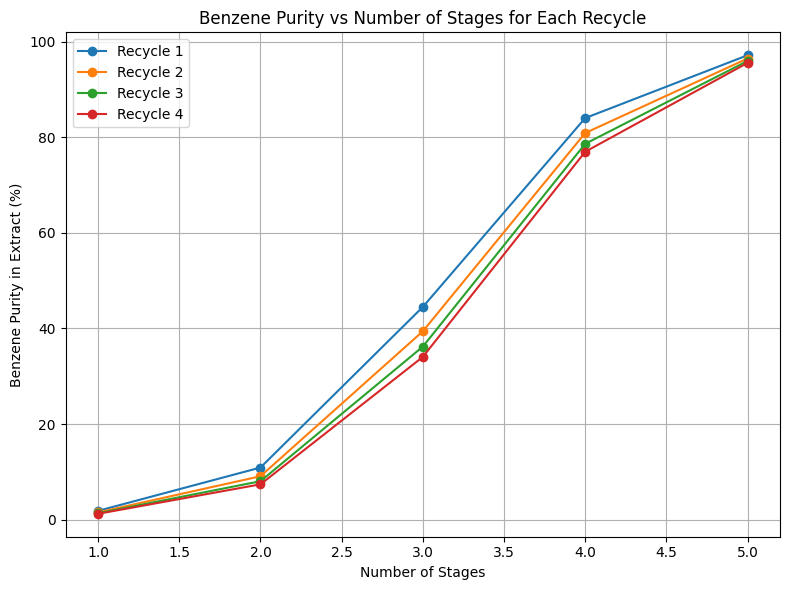

In [ ]:
import matplotlib.pyplot as plt
# Load data
with open('purity_data.json', 'r') as f:
    data = json.load(f)

recycle_purities = data['recycle_purities']

# Plot
plt.figure(figsize=(8, 6))

for recycle_str, purities in recycle_purities.items():
    tray_numbers = list(range(len(purities), 0, -1))
    plt.plot(tray_numbers, purities, marker='o', label=f"Recycle {recycle_str}")

plt.xlabel("Number of Stages")
plt.ylabel("Benzene Purity in Extract (%)")
plt.title("Benzene Purity vs Number of Stages for Each Recycle")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



**Plot for Raffinate vs Extract Flow for All Trays Across Recycles**

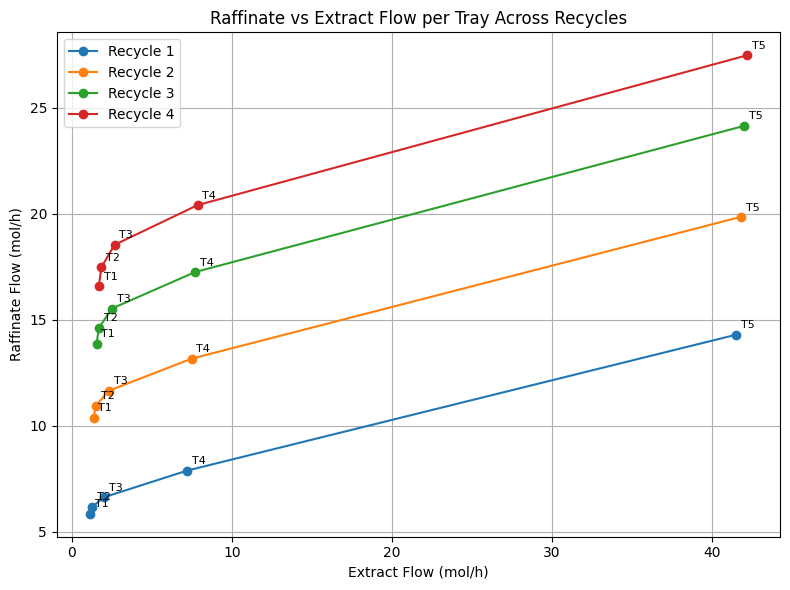

In [ ]:
import matplotlib.pyplot as plt
import json

# Load data
with open('purity_data.json', 'r') as f:
    data = json.load(f)

recycle_tray_flows = data.get('recycle_tray_flows', {})

if recycle_tray_flows:
    plt.figure(figsize=(8, 6))

    for recycle_iter, flows in recycle_tray_flows.items():
        extract_vals = [flow[0] for flow in flows]
        raffinate_vals = [flow[1] for flow in flows]

        # Reverse tray order for top-to-bottom numbering
        tray_nums = list(range(len(flows), 0, -1))  # e.g., [5,4,3,2,1] for 5 trays

        plt.plot(extract_vals, raffinate_vals, marker='o', linestyle='-', label=f"Recycle {recycle_iter}")

        # Annotate with tray numbers (top to bottom)
        for i, (x, y) in enumerate(zip(extract_vals, raffinate_vals)):
            tray_label = f"T{tray_nums[i]}"
            plt.annotate(tray_label, (x + 0.3, y + 0.3), fontsize=8)

    plt.xlabel("Extract Flow (mol/h)")
    plt.ylabel("Raffinate Flow (mol/h)")
    plt.title("Raffinate vs Extract Flow per Tray Across Recycles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**Plot for Recycle Ratio vs Final Tray Benzene Purity**

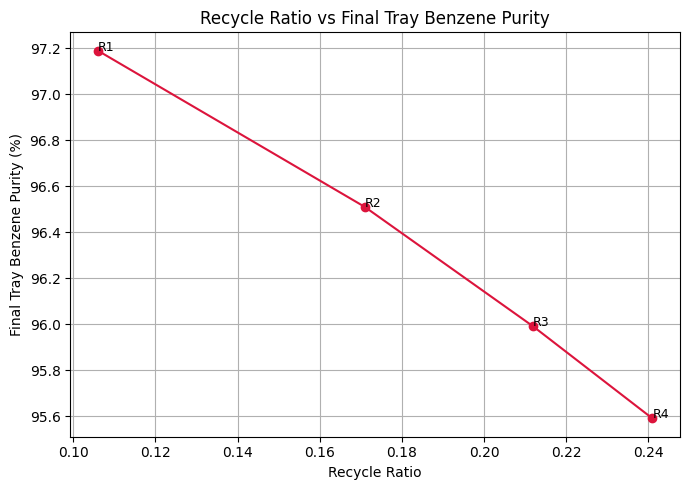

In [ ]:
import matplotlib.pyplot as plt
import json

# Load the saved data
with open('purity_data.json', 'r') as f:
    data = json.load(f)

recycle_ratios = data.get('recycle_ratios', {})
recycle_purities = data.get('recycle_purities', {})

# === Plot: Recycle Ratio vs Final Tray Benzene Purity ===
if recycle_ratios and recycle_purities:
    x_vals = []
    y_vals = []

    for iteration_str, ratio in recycle_ratios.items():
        # Get final tray purity of that recycle
        final_purity = recycle_purities[iteration_str][0]
        x_vals.append(ratio)
        y_vals.append(final_purity)

    plt.figure(figsize=(7, 5))
    plt.plot(x_vals, y_vals, marker='o', linestyle='-', color='crimson')
    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
        plt.annotate(f"R{i+1}", (x, y), fontsize=9)

    plt.xlabel("Recycle Ratio")
    plt.ylabel("Final Tray Benzene Purity (%)")
    plt.title("Recycle Ratio vs Final Tray Benzene Purity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**4. Simulation for plotting stages composition**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

# Constants
initial_feed_flow = 55.0  # mol/h
il_flow = 0.79            # mol/h
benzene_in_feed = 0.8625
heptane_in_feed = 0.1374
benzene_eff = 0.85
heptane_eff = 0.05

# Plotting function
def plot_extraction_column(x_vals, y_vals, iteration=None):
    num_stages = len(y_vals)
    fig, ax = plt.subplots(figsize=(6, 6))

    for i in range(num_stages):
        y = num_stages - i - 1
        ax.hlines(y=y, xmin=0, xmax=1, color='black', linewidth=2)
        ax.text(1.05, y, f"Stage {i+1}", verticalalignment='center')

    # Raffinate (x values): upward (bottom to top)
    for i, x in enumerate(x_vals):
        y = num_stages - i
        ax.annotate(f"x{i} = {x:.2f}", xy=(-0.4, y - 0.4), color='blue', fontsize=10)
        if i < num_stages:
         ax.arrow(-0.2, y - 1, 0, 0.8, head_width=0.05, head_length=0.1, fc='blue', ec='blue')  # shorter upward arrow


# Extract (y values): downward (top to bottom)
    for i, y_val in enumerate(y_vals):
       y = num_stages - i - 1
       ax.annotate(f"y{i+1} = {y_val:.2f}", xy=(1.1, y - 0.4), color='green', fontsize=10)  # slight upward shift

       if i < num_stages:
        ax.arrow(1.0, y, 0, -0.8, head_width=0.05, head_length=0.1, fc='green', ec='green')  # shorter downward arrow


    ax.set_ylim(-0.5, num_stages + 0.5)
    ax.set_xlim(-0.5, 1.5)
    ax.axis('off')
    title = "Multistage Extraction Column with Mole Fractions"
    if iteration is not None:
        title += f" (Recycle Iteration {iteration})"
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Tray simulation function
def simulate_trays(benzene_flow, heptane_flow, num_trays):
    tray_data = []
    for tray in range(num_trays, 0, -1):
        benzene_to_extract = benzene_eff * benzene_flow
        heptane_to_extract = heptane_eff * heptane_flow
        il_in_extract = il_flow

        benzene_in_raffinate = benzene_flow - benzene_to_extract
        heptane_in_raffinate = heptane_flow - heptane_to_extract

        total_extract = benzene_to_extract + heptane_to_extract + il_in_extract
        total_raffinate = benzene_in_raffinate + heptane_in_raffinate

        extract_composition = {
            'benzene': benzene_to_extract / total_extract,
            'heptane': heptane_to_extract / total_extract,
            'il': il_in_extract / total_extract
        }

        raffinate_composition = {
            'benzene': benzene_in_raffinate / total_raffinate,
            'heptane': heptane_in_raffinate / total_raffinate
        }

        tray_data.append({
            'tray': tray,
            'extract_composition': extract_composition,
            'raffinate_composition': raffinate_composition,
            'benzene_flow': benzene_in_raffinate,
            'heptane_flow': heptane_in_raffinate
        })

        benzene_flow = benzene_in_raffinate
        heptane_flow = heptane_in_raffinate

    return tray_data[::-1], benzene_flow, heptane_flow

# Main function with widgets
def run_simulation(num_trays, num_iterations, user_extract, user_raffinate):
    benzene_rcy2 = 0.0
    heptane_rcy2 = 0.0

    for iteration in range(1, num_iterations + 1):
        total_feed = initial_feed_flow + benzene_rcy2 + heptane_rcy2
        new_benzene_frac = (initial_feed_flow * benzene_in_feed + benzene_rcy2) / total_feed
        new_heptane_frac = (initial_feed_flow * heptane_in_feed + heptane_rcy2) / total_feed

        benzene_flow = total_feed * new_benzene_frac
        heptane_flow = total_feed * new_heptane_frac

        tray_data, final_benzene, final_heptane = simulate_trays(benzene_flow, heptane_flow, num_trays)

        x_vals = [data['raffinate_composition']['benzene'] for data in tray_data]
        x_vals.insert(0, new_benzene_frac)  # x0 (feed composition)
        y_vals = [data['extract_composition']['benzene'] for data in tray_data]

        print(f"\nRecycle Iteration {iteration}:")
        for i, data in enumerate(tray_data):
            print(f"  Tray {i+1}: x_Benzene = {data['raffinate_composition']['benzene']:.4f}, "
                  f"y_Benzene = {data['extract_composition']['benzene']:.4f}")

        plot_extraction_column(x_vals, y_vals, iteration)

        benzene_rcy2 = final_benzene
        heptane_rcy2 = final_heptane

# Sliders for interactive input
interact(run_simulation,
         num_trays=IntSlider(value=3, min=1, max=10, step=1, description='Trays'),
         num_iterations=IntSlider(value=5, min=1, max=10, step=1, description='Recycle Iters'),
         user_extract=FloatSlider(value=25.0, min=10.0, max=50.0, step=1.0, description='Extract Flow'),
         user_raffinate=FloatSlider(value=25.0, min=10.0, max=50.0, step=1.0, description='Raffinate Flow'))

interactive(children=(IntSlider(value=3, description='Trays', max=10, min=1), IntSlider(value=5, description='…

<function __main__.run_simulation(num_trays, num_iterations, user_extract, user_raffinate)>